# Deep Learning in PyTorch — End-to-End Workflow

In this notebook, we will implement a complete example of **Deep Learning with PyTorch**, training a neural network to classify **breast tumors (benign vs malignant)** using the *Breast Cancer* dataset from *scikit-learn*.

The workflow will follow all the main phases of a supervised DL project:

1. **Data Loading and Exploration**  
   → loading, normalization, and feature analysis.
2. **Creating Dataset and DataLoader**  
   → converting to tensors and batching the data.
3. **Model Definition (Feedforward Network)**  
   → architecture with fully connected layers and ReLU activations.
4. **Choosing the Loss Function and Optimizer**  
   → for example, `CrossEntropyLoss` and `Adam`.
5. **Training Loop with Loss Curve**  
   → training for epochs and monitoring convergence.
6. **Validation on the Test Set**  
   → calculating accuracy and confusion matrix.
7. **Performance Visualization**  
   → plots of loss, accuracy, and confusion matrix.
8. **Model Interpretation**  
   → analysis of feature importance (Captum).
9. **Saving and Loading the Model**  
   → exporting and reusing for future predictions.

> Final objective: to practically understand **how to design, train, and evaluate**
> a feedforward neural network end-to-end in PyTorch.

In [1]:
# Environment Setup 

#!pip install torch torchvision numpy pandas matplotlib shap captum > /dev/null

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import shap
import captum
from captum.attr import IntegratedGradients

# Device Verification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Environment ready — PyTorch, SHAP, and Captum installed and imported.")

Using device: cpu
Environment ready — PyTorch, SHAP, and Captum installed and imported.


## 1. Loading and Exploring the Dataset

The *Breast Cancer* dataset from *scikit-learn* contains **569 samples** and **30 numerical variables**  
extracted from breast tissue images.  
The objective is to predict whether a tumor is **malignant (0)** or **benign (1)** based on these measurements.

Each feature represents a statistical characteristic of the cells (e.g., mean radius, texture, area, symmetry, concavity, etc.),  
providing a useful foundation for training supervised classification models.

In [2]:
# Loading the Breast Cancer dataset from scikit-learn
data = load_breast_cancer()
X = data.data       # feature matrix (numerical values)
y = data.target     # target vector (labels: 0 or 1)

# Basic Information about the Dataset
print("Feature dimensions:", X.shape)    # (n_samples, n_features)
print("Target dimensions:", y.shape)     # (n_samples,)
print("Classes:", np.unique(y))          # present classes → 0 = malignant, 1 = benign

Feature dimensions: (569, 30)
Target dimensions: (569,)
Classes: [0 1]


### Preprocessing

To prepare the data for the model:

- **We normalize** all features using `StandardScaler` to bring them to the same scale (mean = 0, standard deviation = 1).  
- **We split** the dataset into a **training set (80%)** and a **test set (20%)** to evaluate the model on unseen data.

In [3]:
# Data Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train–Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)

Train size: (455, 30) (455,)
Test size: (114, 30) (114,)


## 2. Creation of Datasets and DataLoaders

We convert the NumPy arrays into **PyTorch tensors** and use **DataLoaders** to efficiently manage  
data loading during training:

- The tensors represent the features and targets in a format compatible with the neural network.  
- The DataLoaders split the data into **mini-batches** and (during training) **shuffle** them at each epoch to improve generalization.

In [4]:
# Conversion of NumPy Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)   # numerical features → float32 (model input)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)      # integer targets → long (classification labels)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.long)

# Creation of datasets (input, label)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

# DataLoader: divides the data into mini-batches and manages the reading order.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

##### Main Parameters of the DataLoader

- **batch_size = 32** → processes the data in blocks of 32 samples at a time, making training more efficient (especially on GPU).  
- **shuffle = True** → shuffles the data at each epoch to improve generalization and prevent the model from learning the order of the samples.  
- **shuffle = False** → keeps the data order fixed, ensuring consistent and reproducible evaluation during the testing phase.


## 3. Model Definition

We define a simple yet effective **feedforward neural network**, composed of:

- **Input layer** with 30 neurons (one for each feature of the dataset)  
- **Hidden layer** with 32 neurons and **ReLU** activation function  
- **Output layer** with 2 neurons, corresponding to the two classes (*malignant* / *benign*), trained with **CrossEntropyLoss** for binary classification

In [5]:
# Definition of the neural network model for breast cancer classification
class BreastCancerModel(nn.Module):
    def __init__(self):
        super().__init__()
        # First layer: 30 input features → 32 neurons
        self.fc1 = nn.Linear(30, 32)
        
        # Second layer: 32 → 1 output (probability of "malignant")
        self.fc2 = nn.Linear(32, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # converts logits → probabilities [0,1]

    def forward(self, x):
        # Forward pass
        x = self.relu(self.fc1(x))   # input → layer 1 → ReLU
        x = self.fc2(x)              # layer 2 → raw logit
        x = self.sigmoid(x)          # logit → probability of positive class
        return x


# Model creation and transfer to the selected device (CPU/GPU)
model = BreastCancerModel().to(device)
print(model)


BreastCancerModel(
  (fc1): Linear(in_features=30, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


## 4. Cost Function and Optimizer

To train the network, we define:

- **Cost Function:** `CrossEntropyLoss`, suitable for **multiclass/binary classification** problems.  
- **Optimizer:** `Adam` with a *learning rate* = **0.001**, which combines the advantages of SGD and automatic adjustment of the weight update step.

In [6]:
# Definition of loss function and optimizer
criterion = nn.BCELoss()                   # measures error between model output and true class (binary classification)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # updates weights using Adam optimizer (learning rate = 0.001)

**Learning rate (Adam = 0.001):** controls how quickly the model updates the weights — too high → unstable, too low → slow learning.

## 5. Training loop

During training, the model learns iteratively from the data over multiple **epochs**.  
In each epoch, the following fundamental steps are executed:

1. **Forward pass** → the model processes the batches and produces predictions  
2. **Loss calculation** → the error between predictions and actual values is measured  
3. **Backward pass** → gradients are computed via backpropagation  
4. **Weights update** → the optimizer modifies the parameters to reduce the loss  

At the end of each epoch, we print the **average loss** to monitor the convergence of the training.

In [7]:
# Training loop
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()          # set model to training mode
    epoch_loss = 0         # accumulate mean loss per epoch
    
    for X_batch, y_batch in train_loader:   # iterate through training batches
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float()  # reshape y_batch to (batch, 1)
        
        # Forward pass → prediction and loss calculation
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass → weight update
        optimizer.zero_grad()   # reset accumulated gradients
        loss.backward()         # compute gradients via backpropagation
        optimizer.step()        # update model parameters
        
        epoch_loss += loss.item()   # accumulate batch loss
    
    # Mean loss per epoch
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/50, Loss: 0.6064
Epoch 2/50, Loss: 0.4795
Epoch 3/50, Loss: 0.3844
Epoch 4/50, Loss: 0.3038
Epoch 5/50, Loss: 0.2464
Epoch 6/50, Loss: 0.2228
Epoch 7/50, Loss: 0.1727
Epoch 8/50, Loss: 0.1548
Epoch 9/50, Loss: 0.1374
Epoch 10/50, Loss: 0.1208
Epoch 11/50, Loss: 0.1082
Epoch 12/50, Loss: 0.1281
Epoch 13/50, Loss: 0.0928
Epoch 14/50, Loss: 0.0879
Epoch 15/50, Loss: 0.0853
Epoch 16/50, Loss: 0.0823
Epoch 17/50, Loss: 0.0790
Epoch 18/50, Loss: 0.0722
Epoch 19/50, Loss: 0.0689
Epoch 20/50, Loss: 0.0678
Epoch 21/50, Loss: 0.0624
Epoch 22/50, Loss: 0.0622
Epoch 23/50, Loss: 0.0644
Epoch 24/50, Loss: 0.0592
Epoch 25/50, Loss: 0.0616
Epoch 26/50, Loss: 0.0553
Epoch 27/50, Loss: 0.0562
Epoch 28/50, Loss: 0.0514
Epoch 29/50, Loss: 0.0590
Epoch 30/50, Loss: 0.0479
Epoch 31/50, Loss: 0.0474
Epoch 32/50, Loss: 0.0461
Epoch 33/50, Loss: 0.0500
Epoch 34/50, Loss: 0.0443
Epoch 35/50, Loss: 0.0435
Epoch 36/50, Loss: 0.0436
Epoch 37/50, Loss: 0.0451
Epoch 38/50, Loss: 0.0413
Epoch 39/50, Loss: 0.

## 6. Validation on the Test Set
We use `torch.no_grad()` because during validation **we do not compute gradients** (they are not needed, as the weights have already been trained).

In [8]:
# Model evaluation on the test set
model.eval()                      # evaluation mode (no weight updates)
correct, total = 0, 0

with torch.no_grad():              # no gradient computation during evaluation
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)                  # model predictions
        predicted = (outputs > 0.5).long()        # thresholding at 0.5 for binary classification
        total += y_batch.size(0)                  # total number of samples
        correct += (predicted.squeeze() == y_batch).sum().item()  # count correct predictions

# Accuracy calculation and display
accuracy = correct / total
print(f"Test set accuracy: {accuracy:.4f}")

Test set accuracy: 0.9561


## 7. Analysis of Results

To evaluate the model's learning, we observe the **trend of the loss** during the training epochs.  
A loss curve that **decreases progressively** indicates that the model is improving its ability to correctly predict the classes.  
Conversely, if the loss stabilizes or increases, it may be necessary to **tune the hyperparameters** (e.g., learning rate, number of neurons, or epochs).

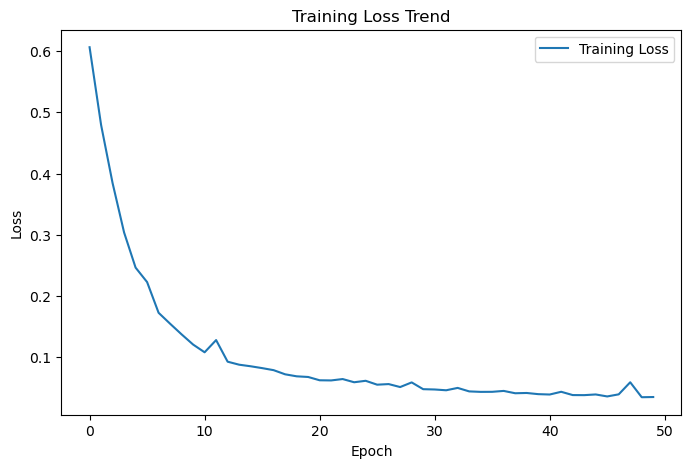

In [9]:
# Visualization of loss over epochs
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Trend')
plt.legend()
plt.show()


## 8. Model Interpretability — Captum

After training and validating the model, it is essential to understand **how** and **why** it makes certain decisions.  
**Integrated Gradients (IG)** is a method for understanding **which features have the most influence** on the decisions of a neural network.

It works as follows:
1. Start from a **baseline** (a neutral input, e.g., all features = 0 or the mean of the training data).  
2. Gradually “shift” the baseline towards the **actual input** of the model.  
3. At each step, calculate **how much the prediction changes with respect to the features** (the gradients).  
4. The **average of all these changes** indicates the importance of each feature.

**Intuition:**
- If changing a feature results in a significant variation in the prediction → the feature is **important**.  
- If the prediction remains stable → the feature has **little impact**.  

Integrated Gradients is useful because:
- It is **specific to neural networks**, yet based on a clear mathematical principle.  
- It provides a “continuous” explanation of the contribution of each feature, starting from a neutral point.

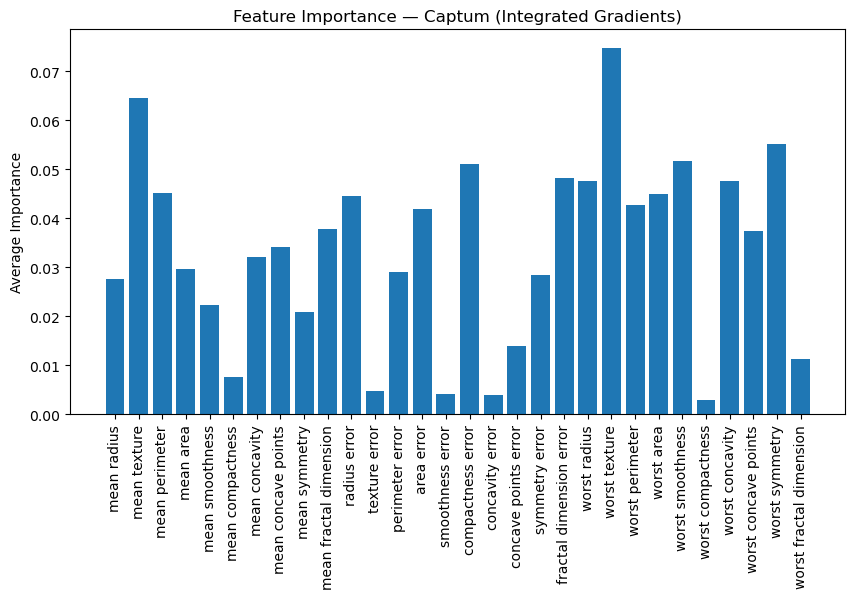

In [10]:
# 1. Create the Integrated Gradients object
# Links the model to Captum to compute feature importance
ig = IntegratedGradients(model)

# 2. Retrieve one batch of test data
X_batch, y_batch = next(iter(test_loader))  # 'iter()' creates an iterator, 'next()' fetches the first batch (X, y)
X_batch, y_batch = X_batch.to(device), y_batch.to(device)

# 3. Compute feature attributions for a target class (e.g., 0 = malignant)
# Each value shows how much a feature influenced the prediction
attr = ig.attribute(X_batch, target=0)

# 4. Compute average feature importance across the batch
# Take the absolute value, compute the mean, and convert to NumPy for plotting
importances = attr.abs().mean(dim=0).cpu().numpy()

# 5. Visualize the most influential features
plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), data.feature_names, rotation=90)
plt.title("Feature Importance — Captum (Integrated Gradients)")
plt.ylabel("Average Importance")
plt.show()


- Taller bars → features with a greater impact on the model's decision  
- We can compare the classes to understand **which features drive** the different predictions.

## 9. Saving and Loading the Model

After training, we can **save the model weights** for reuse without having to retrain it.  
Using `state_dict()`, we save only the learned parameters (not the entire architecture), and we can then **reload them** into a model with the same structure.

This is useful for:
- Reusing the model in other scripts or notebooks  
- Making predictions on new data  
- Resuming training from a saved state

In [11]:
# Save the model weights
torch.save(model.state_dict(), "breast_cancer_model.pth")   # save only the learned parameters

# Reload the model
loaded_model = BreastCancerModel().to(device)               # recreate the same architecture
loaded_model.load_state_dict(torch.load("breast_cancer_model.pth"))  # load saved weights
loaded_model.eval()                                         # set to evaluation mode
print("Model reloaded and ready for use.")

Model reloaded and ready for use.


## Conclusions

In this notebook, we have followed a **complete Deep Learning workflow with PyTorch**, from data preparation to the interpretation of the model's decisions.

Specifically, we have:
- Prepared the data using `Dataset` and `DataLoader`  
- Defined a neural network (`nn.Module`) with a loss function and optimizer  
- Trained and validated the model, assessing its performance on the test set  
- Saved and reloaded the weights for future reuse  
- Interpreted the predictions using **Integrated Gradients (Captum)**